# Wstęp

Zadanie nr 14 stanowi rozszerzenie wprowadzenia do zagadnienia głębokich modeli uczenia ze wzmocnieniem (_Deep Reinforcement Learning_, **DRL**), w którym omówione zostaną bardziej zaawansowane modele (w szczególności typu _policy gradient_ oraz aktor-krytyk).

## Cel ćwiczenia

Celem ćwiczenia jest zapoznanie z:

- metodami _policy gradient_ oraz aktor-krytyk w bibliotece _Stable-Baselines3_
- sposobem przygotowywania środowisk dla tego typu modeli
- dostępnymi hiperparametrami i modyfikacjami metod


## Metody _policy gradient_

W odróżnieniu od omawianych poprzednio metod głębokiego uczenia ze wzmocnieniem opartych na funkcjach wartości (gdzie uczymy się ewaluować akcje w dowolnym stanie), w przypadku _policy gradient_ próbujemy bezpośrednio ustalić postać strategii optymalnej $\pi^*$. W tym celu stosujemy postać sparametryzowaną $\pi_\theta$, gdzie $\theta$ jest zbiorem parametrów aktualizowanych podczas uczenia:

$$\pi_\theta(\mathbf{s}, \mathbf{a}) = p(\mathbf{a} | \mathbf{s}, \theta)$$

Celem trenowania modelu strategii odbywać się będzie poprzez aktualizowanie parametrów w taki sposób, aby maksymalizować oczekiwaną wartość zwrotu. Uczenie może odbywać się na różne sposoby - w przypadku metod głębokiego uczenia ze wzmocnieniem, model strategii (sieć neuronową) trenować będziemy metodą gradientową.

Funkcja nagrody (której metody _policy gradient_ używają jako funkcji celu) będzie zdefiniowana w następujący sposób:

$$\mathcal{L}(\theta) = \sum_{\mathbf{s}\in\mathbf{S}} d^\pi(\mathbf{s})V^\pi(\mathbf{s}) = \sum_{\mathbf{s}\in\mathbf{S}} d^\pi(\mathbf{s})\sum_{\mathbf{a}\in\mathbf{A}}\pi_\theta(\mathbf{a} | \mathbf{s}) Q^\pi(\mathbf{s}, \mathbf{a}),$$

gdzie $d^\pi(\mathbf{s})=\lim_{t\rightarrow\infty}p(\mathbf{s}_t=\mathbf{s}_0, \pi_\theta)$ jest rozkładem stanów _on-policy_ przy strategii $\pi$) - prawdopodobieństwo, że w kroku czasowym $t$ uzyskamy stan $\mathbf{s}$ postępując według strategii $\pi_\theta$, $V^\pi(\mathbf{s})$ to funkcja wartości (oczekiwana wartość zwrotu), a $Q^\pi(\mathbf{s}, \mathbf{a})$ to funkcja jakości.

W literaturze występuje wiele metod uczenia uczenia _policy gradient_. Jednym z aspektów rozróżniajacych je jest sposób obliczania całkowitej wartości zwrotu (w każdym kroku w środowisku, wykorzystując dotychczasową wartość nagród jako estymację funkcji jakości, lub np. przechodząc cały epizod w środowisku).

### Metody aktor-krytyk

Jedną z metod ustalania wartości funkcji jakości jest podejście **aktor-krytyk**. Wykorzystujemy nim dwa modele: **aktor** (model strategii) jest wykorzystywany do podejmowania akcji w środowisku, oraz **krytyk** (model funkcji jakości), służący do estymacji wartości funkcji jakości $Q$.

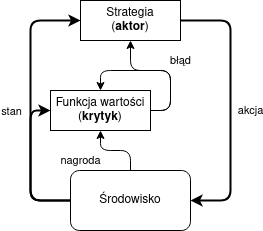

Trenowanie modelu aktor-krytyk polega na uczeniu parametrów $w$ funkcji wartości (krytyka) w celu poprawnego określania wartości zwrotu ($Q$ lub $V$) oraz trenowaniu modelu strategii $\pi_\theta(\mathbf{s}, \mathbf{a})$ (aktora) na podstawie sprzężenia zwrotnego dostarczanego przez krytyka, obserwującego i oceniającego podejmowane akcje. Algorytm dzałania wygląda następująco:

1. Zainicjalizuj stan początkowy $\mathbf{s}_1$, parametry aktora $\theta$ i krytyka $w$
2. Próbkuj akcję $\mathbf{a}_1 \sim \pi_\theta(\mathbf{a} | \mathbf{s})$
3. W każdym kroku czasowym $t = 1, 2, \dots, T$:
4. Pobierz wartość nagrody $r_t$ i następny stan $\mathbf{s}_{t+1}$
5. Próbkuj akcję w następnym kroku $\mathbf{a}_{t+1} \sim \pi_\theta(\mathbf{a}_{t+1} | \mathbf{s}_{t+1})$
6. Zaktualizuj parametry strategii $\theta$ wg gradientu funkcji celu
7. Zaktualizuj parametry funkcji wartości na podstawie błędu pomiędzy wartością funkcji $Q$ w kolejnym kroku, a sumą funkcji $Q$ z aktualnego oraz uzyskanej nagrody.

Najczęściej używa się dwóch współczynników uczenia: osobno dla trenowania aktora $\alpha_\theta$ oraz krytyka $\alpha_w$.


### A3C/A2C

Algorytmy A3C (_Asynchronous Advantage Actor-Critic_) i A2C (_Advantage Actor-Critic_) [[Mnih et al.](https://arxiv.org/abs/1602.01783)] to dwie wersje metody głębokiego uczenia ze wzmocnieniem oparte na architekturze aktor-krytyk. Metoda ta opiera się na wykorzystaniu wspólnej sieci neuronowej do predykcji akcji (model strategii) oraz ich ewaluacji (model funkcji wartości), przy użyciu odrębnych wyjść (_heads_). Podejście to bazuje na wykorzystaniu wielu agentów, oddziałujących z własną kopią środowiska przy użyciu indywidualnych zestawów wag sieci i uczących swoje kopie przez określony okres, a następnie synchronizujące się z globalną siecią asynchronicznie (A3C) lub synchronicznie (A2C).

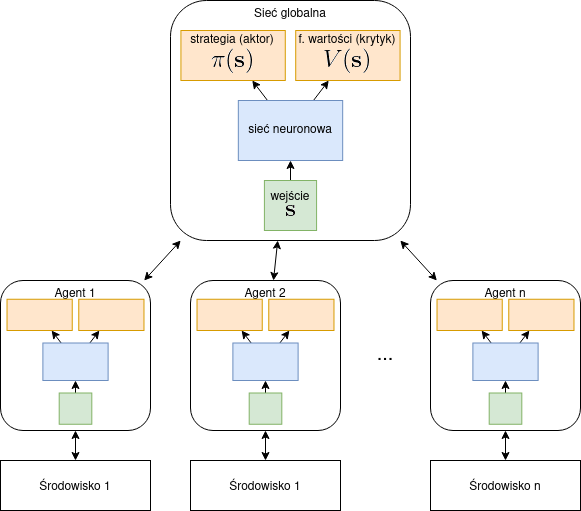

Dzięki zastosowaniu wielu agentów oddziałujących ze swoimi kopiami środowiska, oraz cyklicznemu synchronizowaniu wag z siecią globalną, trenowanie modelu może odbywać się na bardziej zróżnicowanym zbiorze doświadczeń, niż w przypadku pojedynczego agenta, a przez to model powinien zbiegać szybciej, do globalnego optimum bez wykorzystania _experience replay_.

Drugim z ulepszeń zastosowanych w tych metodach jest zastąpienie funkcji jakości $Q$ przez funkcję przewagi $A$. W tym podejściu, model krytyka, zamiast uczyć się wprost wartości funkcji jakości, próbujemy nauczyć się funkcji, która jest różnicą funkcji jakości i funkcji jakości:

$$A(\mathbf{s}, \mathbf{a}) = Q(\mathbf{s}, \mathbf{a}) - V(\mathbf{s})$$

Innymi słowy, chcemy obliczać, o ile lepszy/gorszy będzie wybór akcji $\mathbf{a}$ w stanie $\mathbf{s}$ i postępowanie dalej zgodnie ze strategią od postępowania zgodnie ze strategią bezpośrednio od stanu $\mathbf{s}$.


Podobnie jak poprzednio, skorzystamy z gotowej implementacji metody A3C/A2C z biblioteki [**Stable-Baselines3**](https://stable-baselines.readthedocs.io). Zaczniemy od powtórzenia eksperymentów w środowisku CartPole z poprzedniej listy.


In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay stable-baselines3[extra] > /dev/null 2>&1


In [2]:
import os
import random

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import animation
from pyvirtualdisplay import Display
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import plot_results, load_results
from stable_baselines3.a2c.policies import MlpPolicy

from IPython import display as ipythondisplay


SEED = 13
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

DISPLAY = Display(visible=0, size=(400, 300))
DISPLAY.start()


def visualize_model(model, max_steps=50, env=None):
    """Show how a model works in the environment."""
    env = env or model.get_env()
    obs = env.reset()

    fig, ax = plt.subplots()
    frames = []
    done = False

    while not done:
        frames.append(env.render(mode="rgb_array"))
        with torch.no_grad():
            action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        if len(frames) >= max_steps:
            break

    anim = animation.FuncAnimation(
        fig=fig,
        func=lambda i: ax.imshow(frames[i]),
        frames=range(len(frames)),
        interval=100,
        blit=False,
    )
    plt.close()

    reward_avg, reward_std = evaluate_policy(model, env, n_eval_episodes=100)
    print(f"Reward in episode: {reward_avg:.2f} +/- {reward_std:.2f}")

    return anim.to_jshtml()

ModuleNotFoundError: No module named 'matplotlib'

Sprawdźmy, jakie parametry przyjmuje model A2C oraz jego model strategii (zwróćmy uwagę, że stosujemy strategie odpowiednie dla A2C!).

Zwróćmy uwagę, że implementacja A2C w stable-baselines3 przyjmuje jeden współczynnik uczenia `learnin_rate` (stosowany dla modelu strategii) - współczynnik dla funkcji wartości uzyskiwany jest przez przemnożenie przez parametr `vf_coef`. Z kolei interfejs `MlpPolicy` jest podobny do klasy przeznaczonej dla modelu DQN - szczególnie interesująca jest architektura sieci.


In [ ]:
help(A2C)

In [ ]:
help(MlpPolicy)

Zacznijmy od przetestowania niewytrenowanego modelu w środowisku.


In [ ]:
env = gym.make("CartPole-v1")
model = A2C(MlpPolicy, env)
display(ipythondisplay.HTML(visualize_model(model)))

Analogicznie do zadania 13, spróbujemy wytrenować najprostszy model A2C w celu porównania procesu trenowania i efektów z modelem DQN.


In [ ]:
batch_size = 64
lr = 1e-4
total_timesteps = 100000

env = gym.make("CartPole-v1")
log_dir = "/tmp/vanilla/"
os.makedirs(log_dir, exist_ok=True)  # we have to create this dir - it does not exist
env = Monitor(env, filename=log_dir)

vanilla_a2c = A2C(
    MlpPolicy,
    env,
    learning_rate=lr,
    seed=SEED,
    verbose=1,
)
vanilla_a2c.learn(total_timesteps)
display(ipythondisplay.HTML(visualize_model(vanilla_a2c)))
plot_results([log_dir], total_timesteps, "timesteps", "Vanilla A2C")
results = load_results(log_dir)
print(f"Max reward: {results.r.max()}")

Wyniki są lepsze niż najprostszy DQN, lecz uczenie trwa stosunkowo długo. Moglibyśmy zająć się teraz strojeniem hiperparametrów, ale zanim to zrobimy, to spróbujmy wykorzystać fakt, że A2C może być stosowany do uczenia modelu przy użyciu wielu agentów na raz. W tym celu będziemy musieli zwektoryzować nasze środowisko - posłuży do tego wbudowana w bibliotekę stable-baselines3 funkcja `make_vec_env`. Sprawdźmy jej parametry.


In [ ]:
help(make_vec_env)

Interesującym dla nas parametrem jest liczba środowisk, które będą wykorzystane w trenowaniu modelu. Ponadto, możemy już tutaj przekazać folder do zapisu historii uczenia `monitor_dir`. Spróbujmy stworzyć 4 środowiska i wytrenować model A2C z użyciem 4 agentów. W stable-baselines3 będze to równie proste, jak dla modelu DQN.

Uwaga: oprócz zwektoryzowanych środowisk tworzymy również osobne środowisko ewaluacyjne, które posłuży nam do sprawdzenia wytrenowanego modelu.


In [ ]:
log_dir = "/tmp/vectorized/"
os.makedirs(
    log_dir, exist_ok=True
)  # we have to create this dir - it does not existenv =
eval_env = gym.make("CartPole-v1")  # evaluation environment
vec_env = make_vec_env("CartPole-v1", n_envs=4, monitor_dir=log_dir)

batch_size = 64
lr = 1e-4
total_timesteps = 100000

vectorized_a2c = A2C(
    MlpPolicy,
    vec_env,
    learning_rate=lr,
    seed=SEED,
    verbose=1,
)
vectorized_a2c.learn(total_timesteps)
display(ipythondisplay.HTML(visualize_model(vectorized_a2c, env=eval_env)))
plot_results([log_dir], total_timesteps, "timesteps", "Vectorized A2C")
results = load_results(log_dir)
print(f"Max reward: {results.r.max()}")

## Zadanie 1.

Zbadaj wpływ kilku (liczba środowisk oraz co najmniej 3 inne) wybranych hiperparametrów na trenowanie i działanie modelu A2C (uwaga: oprócz zbadania należy rozumieć, do czego służy dany hiperparametr). Zapisz swoje wnioski i przygotuj wizualizacje uzyskiwanych rezultatów oraz animiacje działania modelu.


## Zadanie 2.

Jedną z zalet metod _policy gradient_ oraz aktor-krytyk jest fakt, że dzięki zastosowaniu modelu strategii możliwe jest działanie modelu w środowiskach z ciągłą przestrzenią akcji. Wybierz dowolne środowisko z ciągłą przestrzenią akcji spośród dostępnych w bibliotece [Gym](https://gym.openai.com/envs) i zastosuj na nim model A2C. Dostrój hiperparametry modelu tak, aby uzyskać poprawne działanie. Zapoznaj się z definicją funkcji nagrody w środowisku.

W przypadku wyboru środowiska z obserwacjami wizualnymi zmodyfikuj wykorzystany model strategii. (Uwaga: proszę mieć na uwadze, że trenowanie modeli A2C dla środowisk o ciągłej przestrzeni akcji jest bardziej złożone obliczeniowo - próba wytrenowania modelu dla bardzo złożonego środowiska może zająć dłużej).
